In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'legend.fontsize': 15})

%matplotlib inline

/Users/jin/opt/anaconda3/envs/lectures/lib/python3.9/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


I have to (for a given token and date range):

    - calculate the hourly return by timestamp
    - calculate the hourly volatility
    - calculate maximum drawdown up to that hour for each hour
    - then plot in a 2x2 grid:
        - hourly return
        - hourly vol
        - maximum drawdown
        - close prices
        - color of each day on the graph
        
The plot can be simply derived once we have its ingredients, i.e. the first three bulletpoints. Note that the "color of each day on the graph" is simply a common requirement for 4 subplots, not some separate subplot of its own. To get the hang of what the data we are provided, let us first fix our token and dates as shown below.

In [2]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = 'BTC'
    AND ts >= '2021-11-05'
    AND ts <  '2021-11-11'
''', 'sqlite:///data/data.db')
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [3]:
prices.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-11-05 00:00:00,61188.45,61531.65,61140.22,61444.50,232.054183,1.423677e+07,BTC,BTC
2021-11-05 01:00:00,61444.49,61537.09,60870.00,60920.77,343.899671,2.105516e+07,BTC,BTC
2021-11-05 02:00:00,60920.68,61840.00,60896.37,61820.72,387.049829,2.374667e+07,BTC,BTC
2021-11-05 03:00:00,61820.72,61960.00,61678.53,61678.53,370.385830,2.290663e+07,BTC,BTC
2021-11-05 04:00:00,61678.53,62364.98,61678.53,62247.05,424.671468,2.637991e+07,BTC,BTC


Note that the hourly close price is already given so the data for drawing the last specified subplot among the 4 subplots is already satisfied. We can focus on the first 3 subplots, i.e. "hourly return", "hourly vol", and "maximum drawdown". 

I start with "hourly return". This can be either based on open or close prices lagged by one hour for either choice. Here, I choose to calculate this with close prices. 

In [4]:
def hourly_return(df): # based on close prices.
    o = df.open
    c = df.close
        
    cc = np.log(c/c.shift(1)) 
    # since the first element of cc would be NA due to the nonexistent first value of c.shift(1)
    # I assign cc's first element like the following
    cc[0] = np.log(c[0]/o[0])

    return cc

For "hourly vol", I resort to the volatility formula seen in class. By default, the lookback period is initiated to 10 but this can be changed according to the user's purpose.

In [5]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
        
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1)) # a series divided by a series
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0)) # ...rolling() creates a new object like .groupby() which you can act on
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0)) # ex) rolling(3).apply(lambda x: x.mean()) / rolling(3).mean()
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

For "maximum drawdown(MDD)", we are instructed to calculate it up to that hour (i.e. no local windows, so thereby considering the whole period up until now) and update it every hour. I choose to base this on close prices for each hour. I derive the MDD by first finding the hourly drawdown(DD) and find its maximum among the observed range of hours which is updated with every hourly data appended to it. 

In [6]:
def max_drawdown(df):
    c = df.close
    
    previous_peaks = c.cummax()
    drawdown = (c - previous_peaks) / previous_peaks
    
    mdd = drawdown.cummin()
    
    return mdd

With the necessary functions for retrieving necessary information for drawing the plots, we proceed with the actual plotting (considering the condition of differing teh color each day on the graph)

In [7]:
def series_plot(data, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

We test this data on BTC for two weeks as specified below. In fact, the parameters listed below will be used via papermill to automate plotting when scaled up to other tokens with the "my_runner.ipynb" file.

In [8]:
token = 'BTC' # parameter list to be used with papermill
from_date = '2021-11-05'
to_date = '2021-11-19'
connection_string = 'sqlite:///data/data.db'

In [9]:
# Parameters
from_date = "2021-12-01 00:00:00"
to_date = "2021-12-15 00:00:00"
token = "AAVE"
connection_string = "sqlite:///data/data.db"


In [10]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [11]:
prices.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 00:00:00,257.102,260.775,255.345,257.078,2730.299,7.039183e+05,AAVE,ETH
2021-12-01 01:00:00,257.149,266.249,255.270,264.816,5752.541,1.516148e+06,AAVE,ETH
2021-12-01 02:00:00,264.755,266.187,262.597,263.125,1559.330,4.124449e+05,AAVE,ETH
2021-12-01 03:00:00,263.184,266.409,261.700,266.257,1647.398,4.336408e+05,AAVE,ETH
2021-12-01 04:00:00,266.384,267.024,264.284,265.502,829.993,2.207369e+05,AAVE,ETH


In [12]:
prices["return"] = hourly_return(prices)
prices["volatility"] = vol_ohlc(prices, lookback = 3)
prices["max_drawdown"] = max_drawdown(prices)

In [13]:
prices.head()

,open,high,low,close,volume,volumeUSD,token,chain,return,volatility,max_drawdown
ts,,,,,,,,,,,
2021-12-01 00:00:00,257.102,260.775,255.345,257.078,2730.299,7.039183e+05,AAVE,ETH,-0.000093,NaN,0.000000
2021-12-01 01:00:00,257.149,266.249,255.270,264.816,5752.541,1.516148e+06,AAVE,ETH,0.029656,NaN,0.000000
2021-12-01 02:00:00,264.755,266.187,262.597,263.125,1559.330,4.124449e+05,AAVE,ETH,-0.006406,NaN,-0.006386
2021-12-01 03:00:00,263.184,266.409,261.700,266.257,1647.398,4.336408e+05,AAVE,ETH,0.011833,0.293420,-0.006386
2021-12-01 04:00:00,266.384,267.024,264.284,265.502,829.993,2.207369e+05,AAVE,ETH,-0.002840,0.169989,-0.006386


In [14]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

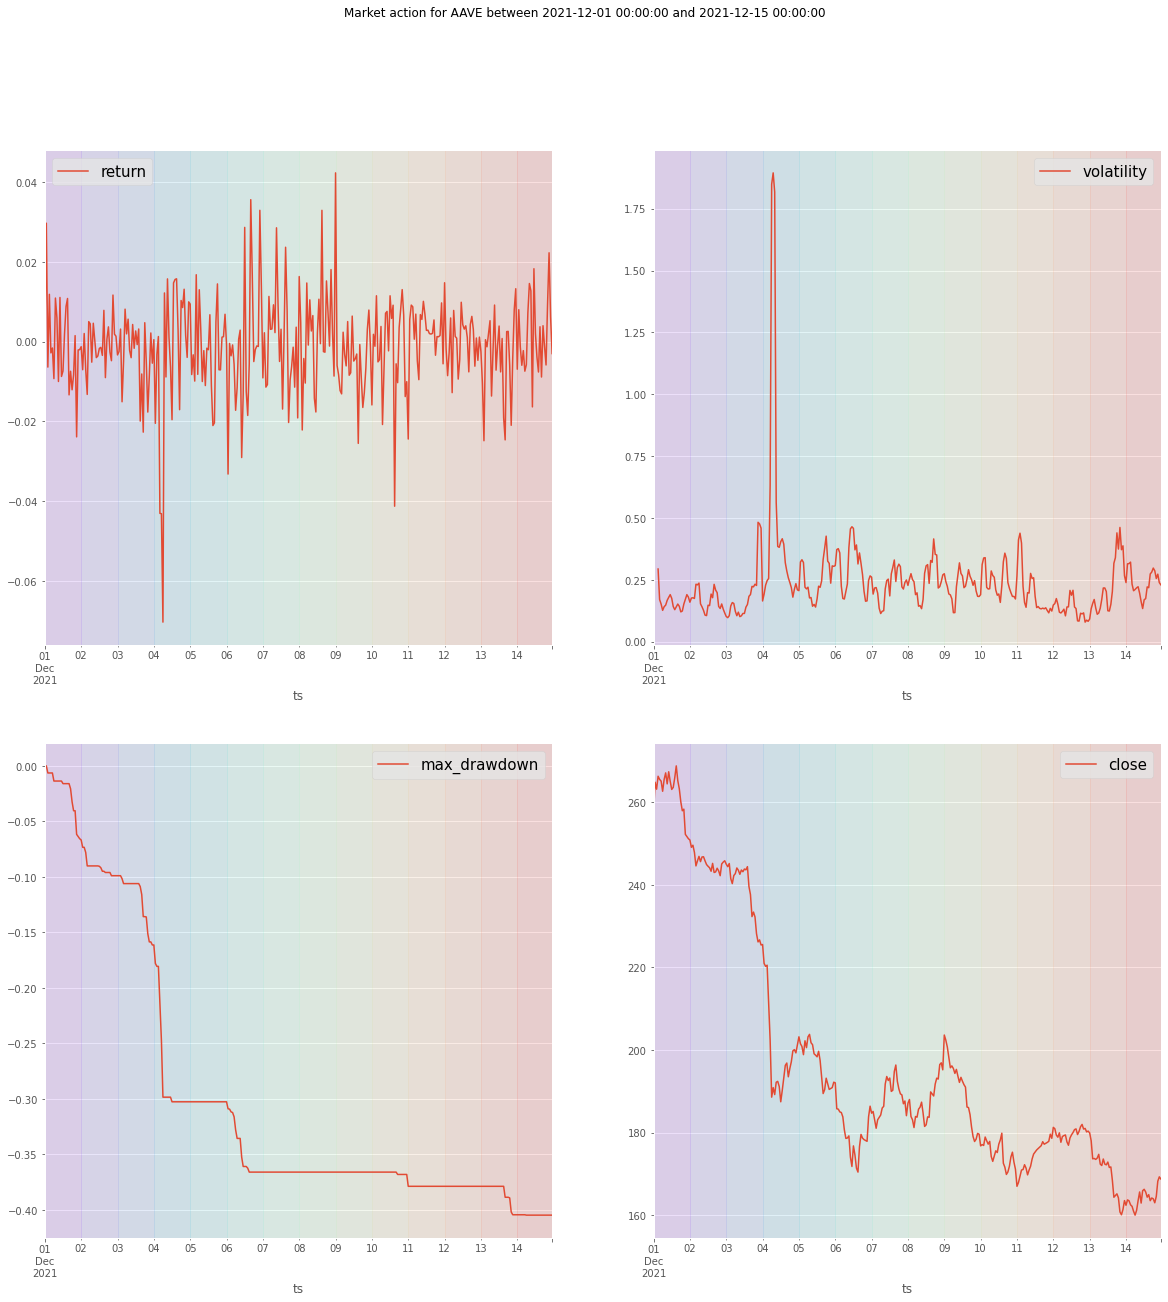

In [15]:
series_plot(prices[['return']], ax=ax[0, 0])
series_plot(prices[['volatility']], ax=ax[0, 1])
series_plot(prices[['max_drawdown']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

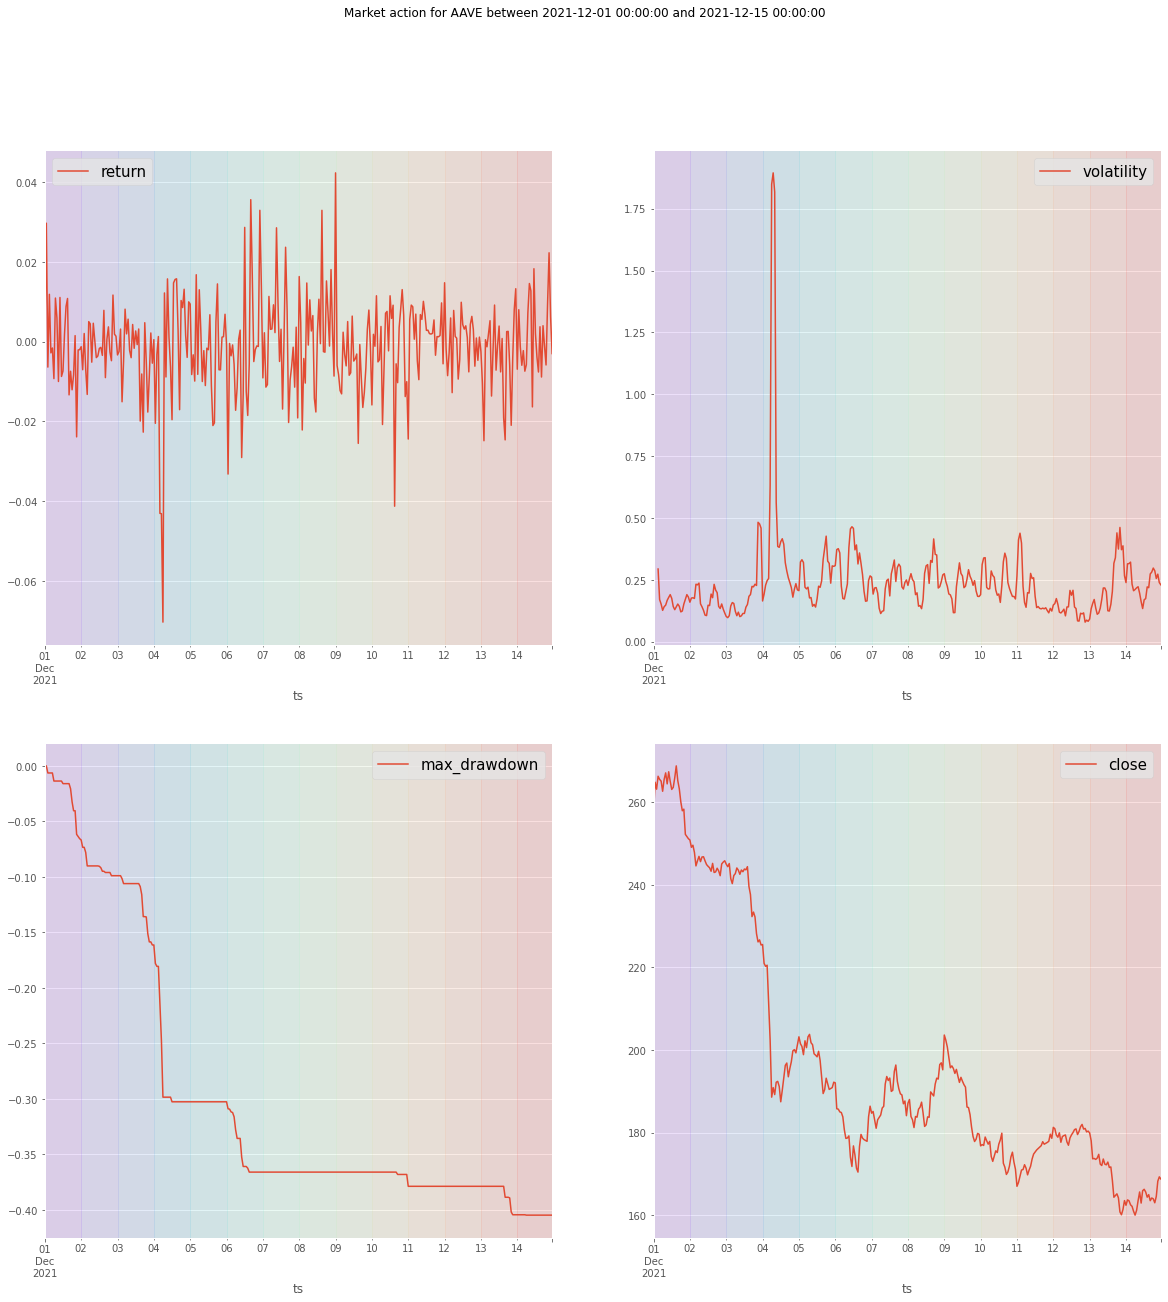

In [16]:
sb.glue('token', token) # taking certain variables in that nb file, save them for global use (even in other files)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas') # as pandas dataframe
sb.glue('summary_plot', fig, encoder='display', display=True)